# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

Importing the required libraries and loading the data:

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import r2_score,f1_score,recall_score,accuracy_score,precision_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.datasets import make_multilabel_classification

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Preprocessing

Exploring the profile Dataframe

In [2]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


The null values match between income and age, while being represented in the age column as '118'.

In [4]:
def clean_profile(profile):
    """
    This function takes the profile df as an input
    Drops the null values
    Changes the date column to datetime format 
    Returns the cleaned profile df
    """
    indices_to_drop=profile[profile['age']==118].index
    profile.drop(index=indices_to_drop,inplace=True)

    profile['became_member_on']=pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
    return profile

profile=clean_profile(profile)

We need to split the channels to columns and change the index to an offer name to be able to get information when merging with other tables

Since the offer_type values are not unique, we can concat them with the difficulty and duration columns to create a unique informative name for each offer, while having the information of the offer within the name.

In [5]:
def clean_portfolio(portfolio):
    """
    This function takes the portfolio df
    Dummifies the channels
    Adds an offer column that contains an offer name
    Returns a clean version of the dataframe
    """
    
    df_channels=pd.get_dummies(portfolio['channels'].apply(pd.Series).stack()).sum(level=0)

    portfolio=pd.concat([portfolio,df_channels],axis=1)

    portfolio.drop(['channels'],axis=1,inplace=True)
    
    a_list=[]
    portfolio['offer']=None
    for i in range(len(portfolio.index)):
        a_list=list([portfolio['offer_type'].iloc[i],str(portfolio['duration'].iloc[i]),str(portfolio['difficulty'].iloc[i])])
        portfolio['offer'].iloc[i]='_'.join(a_list)
    portfolio.drop(['reward','difficulty','duration'],axis=1,inplace=True)

    return portfolio
portfolio=clean_portfolio(portfolio)
portfolio.head()

C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,offer_type,id,email,mobile,social,web,offer
0,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,bogo_7_10
1,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,bogo_5_10
2,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1,informational_4_0
3,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,bogo_7_5
4,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,discount_10_20


The offer id is saved as a dictionary with key being either 'offer_id' or 'offer id', the other key is 'amount:

In [6]:
def clean_transcript(transcript):
    
    """
    This function takes the transcript table
    Extracts the offer id and puts it in a column called 'offer_id'
    Extracts the amount of the offer and puts it in a column called 'amount'
    """
    def get_id(x):
        #This function reads the offer that is saved as a dictionary with two keys 'offer_id' and 'offer id'
        #which refers to the offer id
        try:
            return x['offer_id']
        except:
            return x['offer id']

    transcript['offer_id']=transcript[transcript['event']\
                                      .isin(['offer received','offer completed','offer viewed'])]['value'].apply(get_id)
    amount= [e.get('amount') for e in transcript.value]
    transcript['amount']=pd.Series(amount)
    return transcript

transcript=clean_transcript(transcript)

Now that all dataframes are cleaned, we can merge them on 'offer id' and 'customer id'

In [7]:
def merge_tables(transcript,profile,portfolio):
    
    """
    This function takes the three dataframes and merges them
    Merging the three tables creates a dataframe that doesn't contain amount
    This function returns two dataframes :
    -merged from transcript and profile
    -merged from the three dataframes
    
    
    """
    
    transcript.drop(['value'],axis=1,inplace=True)

    profile.rename({'id':'person'},axis=1,inplace=True)
    portfolio.rename({'id':'offer_id'},axis=1, inplace=True)

    df2=pd.merge(transcript,profile, on='person')


    df3=pd.merge(df2,portfolio, on='offer_id')
    return df2,df3
df2,df3=merge_tables(transcript,profile,portfolio)

Number of completed offers:

In [8]:
(df3['event']=='offer completed').sum()

32444

For the purpose of this analysis we are trying to analyze the behavior of people who completed the offer after receiving and viewing it. Some completed offers have been completed without the participant knowing of the offer, we want to exclude that from our calculations for a better pattern recognition.

In [9]:
def validate_offers(df3):
    df_pivot = df3.pivot_table(index=['person','offer','income','gender','age','offer_type'],columns='event', aggfunc='size', fill_value=0).reset_index()
    df_pivot['valid']=0
    for i in df_pivot.index:
            if df_pivot.iloc[i]['offer completed']<=df_pivot.iloc[i]['offer viewed']:
                df_pivot['valid'].iloc[i]=df_pivot.iloc[i]['offer completed']
            elif df_pivot.iloc[i]['offer completed']>df_pivot.iloc[i]['offer viewed']:
                df_pivot['valid'].iloc[i]=df_pivot.iloc[i]['offer viewed']
    return df_pivot
df_pivot=validate_offers(df3)

df_pivot.head()



C:\Users\ajax2\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


event,person,offer,income,gender,age,offer_type,offer completed,offer received,offer viewed,valid
0,0009655768c64bdeb2e877511632db8f,bogo_5_5,72000.0,M,33,bogo,1,1,1,1
1,0009655768c64bdeb2e877511632db8f,discount_10_10,72000.0,M,33,discount,1,1,1,1
2,0009655768c64bdeb2e877511632db8f,discount_7_10,72000.0,M,33,discount,1,1,0,0
3,0009655768c64bdeb2e877511632db8f,informational_3_0,72000.0,M,33,informational,0,1,1,0
4,0009655768c64bdeb2e877511632db8f,informational_4_0,72000.0,M,33,informational,0,1,1,0


The number of valid completed offers

In [10]:
df_pivot.valid.sum()

26921

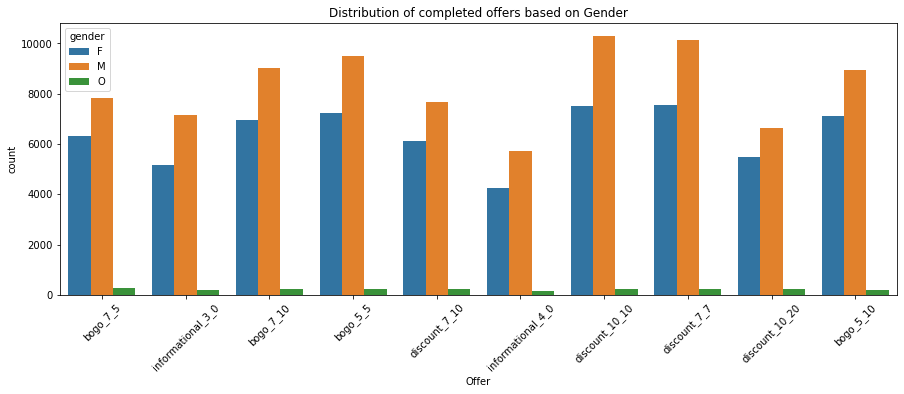

In [11]:
completed_offers = df_pivot[(df_pivot['valid'] == 1)]
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = df3, x = 'offer', hue = 'gender')
plt.title('Distribution of completed offers based on Gender');
plt.xticks(rotation=45);
plt.xlabel('Offer');

# Exploratory Data Analysis

Text(0, 0.5, 'Number of people')

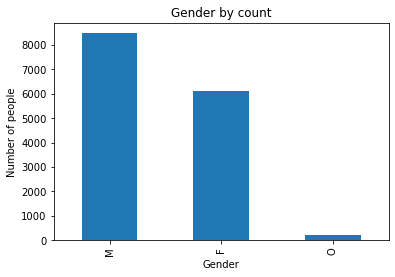

In [12]:
profile['gender'].value_counts().plot(kind='bar')
plt.title('Gender by count')
plt.xlabel('Gender')
plt.ylabel('Number of people')

In [13]:
ratio_of_males_to_females=(profile['gender']=='M').sum()/(profile['gender']=='F').sum()
ratio_of_males_to_females

1.3842388644150758

We expect all the absolute values of Males to be higher than female based on higher ratio of males to females

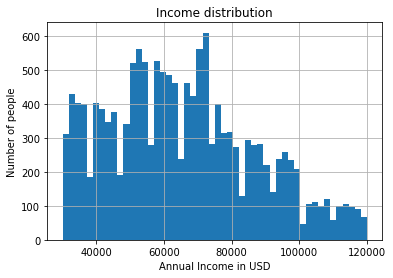

In [14]:
profile['income'].hist(bins=50)
plt.title('Income distribution')
plt.xlabel('Annual Income in USD')
plt.ylabel('Number of people');

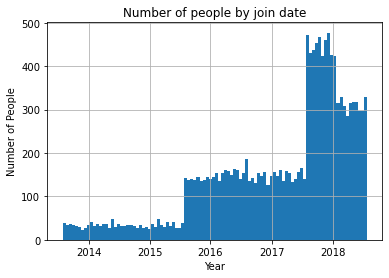

In [15]:
profile['became_member_on'].hist(bins=100)
plt.title('Number of people by join date')
plt.xlabel('Year')
plt.ylabel('Number of People');

In [45]:
profile['age'].mean()

54.39352445193929

Text(0, 0.5, 'Number of people')

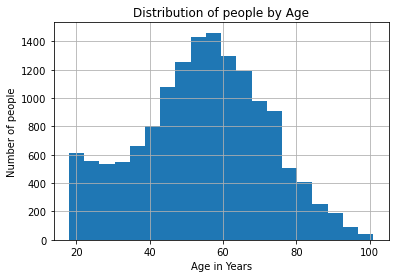

In [17]:
profile['age'].hist(bins=20)
plt.title('Distribution of people by Age')
plt.xlabel('Age in Years')
plt.ylabel('Number of people')

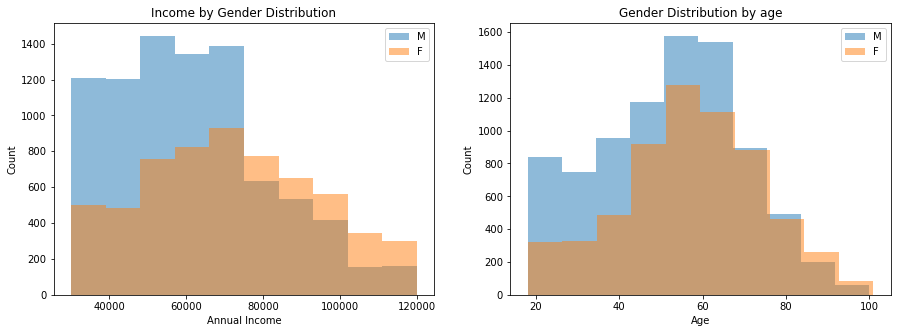

In [18]:
x, (ax1,ax2)=plt.subplots(1,2, figsize=(15,5))

ax1.hist(profile[profile.gender=='M']['income'], alpha=0.5 , label= 'M')
ax1.hist(profile[profile.gender=='F']['income'], alpha=0.5 , label='F')
ax1.set_title('Income by Gender Distribution')
ax1.set_xlabel('Annual Income')
ax1.set_ylabel('Count')
ax1.legend()

ax2.hist(profile[profile.gender=='M']['age'], alpha=0.5 , label= 'M')
ax2.hist(profile[profile.gender=='F']['age'], alpha=0.5 , label='F')
ax2.set_title('Gender Distribution by age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')
ax2.legend()

plt.show()

Now we will look at the Transcript table which contains all the transactions:

In [19]:
transcript.head()

,person,event,time,offer_id,amount
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


Checking the two merged dataframes:

In [20]:
df2.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,F,75,2017-05-09,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,F,75,2017-05-09,100000.0


In [21]:
df2.groupby('person')['amount'].max().max()

1062.28

In [22]:
df2.groupby('person')['amount'].sum().mean()

117.02815514333913

Checking the three merged dataframes:

In [23]:
df3.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income,offer_type,email,mobile,social,web,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,2018-04-26,70000.0,bogo,1,1,0,1,bogo_7_5
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,2018-04-26,70000.0,bogo,1,1,0,1,bogo_7_5


The Mean age of all customers:

In [24]:
df3.age.mean()

54.77928161016095

The average income:

In [25]:
df3.income.mean()

66414.11914922214

Number of events by type:

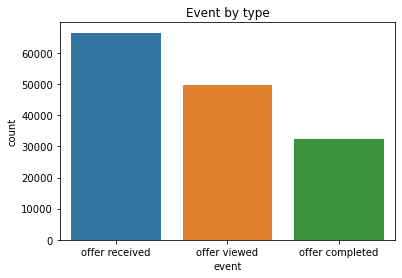

In [27]:
sns.countplot(x='event', data= df3)
plt.title('Event by type');

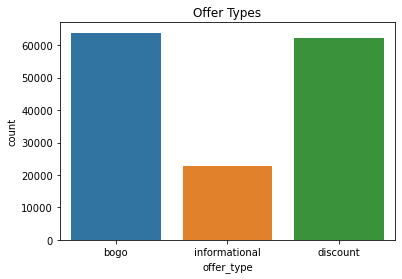

In [28]:
sns.countplot(x='offer_type', data= df3)
plt.title('Offer Types');

In [29]:
df3.head()

,person,event,time,offer_id,amount,gender,age,became_member_on,income,offer_type,email,mobile,social,web,offer
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
2,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,F,75,2017-05-09,100000.0,bogo,1,1,0,1,bogo_7_5
3,e2127556f4f64592b11af22de27a7932,offer received,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,2018-04-26,70000.0,bogo,1,1,0,1,bogo_7_5
4,e2127556f4f64592b11af22de27a7932,offer viewed,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,M,68,2018-04-26,70000.0,bogo,1,1,0,1,bogo_7_5


As expected the number of completed offers for males are greater than the number of valid offers for females, this is why we need to check the ratio

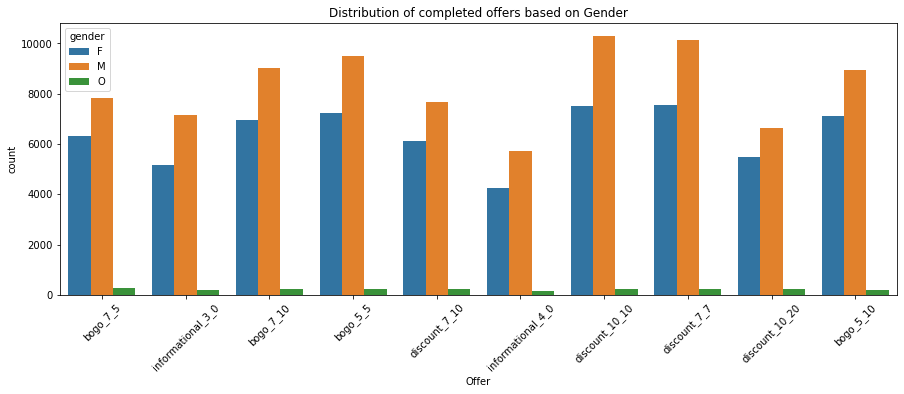

In [30]:
completed_offers = df_pivot[(df_pivot['valid'] == 0)]
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = df3, x = 'offer', hue = 'gender')
plt.title('Distribution of completed offers based on Gender');
plt.xticks(rotation=45);
plt.xlabel('Offer');

Average income of all people:

In [33]:
df_pivot['income'].mean()

65388.59512513129

Average income of people who completed the offer:

In [31]:
df_pivot[(df_pivot['valid']==1)]['income'].mean()

69034.60479748329

Average income of people who didn't complete the offer:

In [32]:
df_pivot[(df_pivot['valid']==0)]['income'].mean()

62681.39835450619

Taking a look at how many offers completed by person

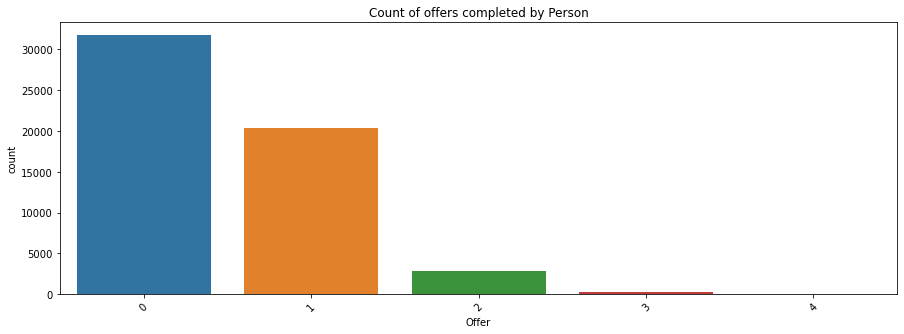

In [35]:
plt.subplots(figsize=(15,5))
ax = sns.countplot(data = df_pivot, x = 'valid')
plt.title('Count of offers completed by Person');
plt.xticks(rotation=45);
plt.xlabel('Offer');

Checking the difference of ratio between the viewed to completed valid offers for males and females

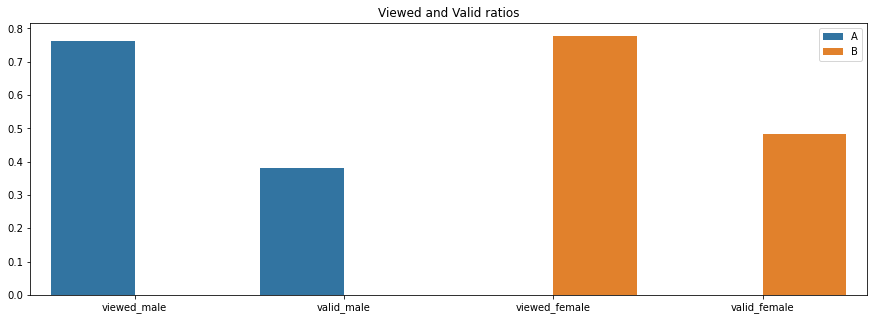

In [36]:
viewed_male=df_pivot[(df_pivot['gender']=='M')&(df_pivot['offer viewed']>0)].shape[0]/df_pivot[df_pivot['gender']=='M'].shape[0]

viewed_female=df_pivot[(df_pivot['gender']=='F')&(df_pivot['offer viewed']>0)].shape[0]/df_pivot[df_pivot['gender']=='F'].shape[0]

valid_male=df_pivot[(df_pivot['gender']=='M')&(df_pivot['valid']>0)].shape[0]/df_pivot[df_pivot['gender']=='M'].shape[0]

valid_female=df_pivot[(df_pivot['gender']=='F')&(df_pivot['valid']>0)].shape[0]/df_pivot[df_pivot['gender']=='F'].shape[0]

raw_data={
    'x':['viewed_male','valid_male','viewed_female','valid_female'],
    'y':[viewed_male,valid_male,viewed_female,valid_female],
    'category':['A','A','B','B']
}
plt.subplots(figsize=(15,5))
sns.barplot(x='x',y='y',hue='category', data=raw_data)
plt.title('Viewed and Valid ratios');


The ratios of completion by males and females:

In [37]:
valid_male/viewed_male,valid_female/viewed_female

(0.5020535158680771, 0.6206429780033842)

# Preparation for Modeling

In [38]:
def prep_for_model(df3):
    """
    This function takes the combined three dataframes 
    Excludes the invalid records
    Splits the offer according to offer type and status of each type
    
    returns the cleaned dataframe
    """

    df=df3.groupby(['person','income','gender','age','event','offer_type'])['time'].count().unstack().unstack().reset_index()
   
    df=df.fillna(0)
    df['year']=df3['became_member_on'].dt.year

    bogo_list=[]
    discount_list=[]
    informational_list=[]
    for x in df.index:
        if df.iloc[x]['bogo']['offer completed']>df.iloc[x]['bogo']['offer viewed']:
            bogo_list.append(x)
        elif df.iloc[x]['discount']['offer completed']>df.iloc[x]['discount']['offer viewed']:
            discount_list.append(x)
        elif df.iloc[x]['informational']['offer completed']>df.iloc[x]['informational']['offer viewed']:
            informational_list.append(x)



    len(bogo_list),len(discount_list),len(informational_list)

    to_drop=list(set(bogo_list+discount_list))
    len(to_drop)

    df=df.drop(to_drop)
    df=df.drop('person',axis=1,level=0)

    df.columns = df.columns.get_level_values(0) + '_' +  df.columns.get_level_values(1)
   
    df_dummies=pd.get_dummies(df.gender_)
    df=pd.concat([df_dummies.drop('O',axis=1),df.drop('gender_',axis=1)],axis=1)
    return df
df=prep_for_model(df3)
df.head()

,F,M,income_,age_,bogo_offer completed,bogo_offer received,bogo_offer viewed,discount_offer completed,discount_offer received,discount_offer viewed,informational_offer completed,informational_offer received,informational_offer viewed,year_
1,0,0,57000.0,40,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,2.0,2017
3,1,0,60000.0,24,2.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,2018
5,1,0,65000.0,19,0.0,0.0,0.0,1.0,4.0,1.0,0.0,1.0,1.0,2018
6,1,0,74000.0,55,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,2018
8,0,1,47000.0,56,1.0,4.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,2018


# The Model:

Splitting the dataframe into two matrices

In [40]:
Y=df.loc[:,['bogo_offer completed','discount_offer completed','informational_offer completed']]
X=df.drop(['bogo_offer completed','discount_offer completed','informational_offer completed'] , axis=1)


Splitting the data into train and test sets:

In [41]:
X_train,X_test, Y_train,Y_test=train_test_split(X,Y,test_size=0.2, random_state=40)

In [43]:
RF=RandomForestClassifier(n_estimators=100 , oob_score = True, n_jobs = -1,
                                  random_state =42, max_features = "auto",
                                  max_leaf_nodes = 100, max_depth=12, warm_start=True)
Mo=MultiOutputClassifier(RF).fit(X_train,Y_train)
Mo_pred=Mo.predict(X_test)



Since there are no libraries in SKlearn that support Multiclass Multioutput Model scoring, we will score each column on its own:

In [44]:
first=recall_score(Y_test.iloc[:,0],Mo_pred[:,0],average='weighted')
second=recall_score(Y_test.iloc[:,1],Mo_pred[:,1],average='weighted')
third=recall_score(Y_test.iloc[:,2],Mo_pred[:,2],average='weighted')
recall=(first+second+third)/3
recall

0.7795771479982007